# Deep Learning

## Assignment 5

In [1]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [9]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.log_device_placement = True
tf_config.allow_soft_placement = True

In [3]:
url = 'http://mattmahoney.net/dc/'
def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify' + filename + '. Can you get to it with a browser!')
    return filename
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [5]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5243, 3083, 12, 6, 195, 2, 3137, 46, 59, 156]


In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape = (batch_size), dtype = np.float32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.float32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen = span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size = 8, num_skips = num_skips, skip_window = skip_window)
    print('\nwith num_skips = %d and skip_widow = %d' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_widow = 1
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_widow = 2
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'a', 'originated', 'term', 'of', 'as', 'originated']


In [7]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2

valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    #Input data.
    train_dataset = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    #Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                      stddev = 1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    #Model.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases, 
                                                    inputs = embed, labels = train_labels, 
                                                    num_sampled = num_sampled, num_classes = vocabulary_size))
    
    #Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    #Compute the similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [10]:
num_steps = 100001

with tf.Session(graph = graph, config = tf_config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict = feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.356594
Nearest to see: understandably nestorius brezhnev huguenots sacrament diger chamorros teachers
Nearest to also: mufti diffeomorphism dieting filmfour exiling sweep meritocracy alkene
Nearest to when: mountainous mush intruder hallucinogens stubbs harlequin prakrit lyc
Nearest to four: voyages mathfrak oxfordshire absolutive ho onetime organum elliott
Nearest to would: ssris guatemalan freezes completions endocarditis sanctuary griswold inconclusive
Nearest to after: xiaoping carver parasitic los marathas beginning denominations resolving
Nearest to such: provability cube riches moynihan colt cramer leeds intellectual
Nearest to five: telophase discount khartoum omnia san dwelling extinguisher empiricist
Nearest to time: mccann hardware discus especial arrests luxuriant insurance sinai
Nearest to into: northampton mild inadequate hdtv belgium lal nieuwe tended
Nearest to war: recovery mahommed chiuchow friendly tasteless struma ailments slove

Average loss at step 62000: 3.240678
Average loss at step 64000: 3.252824
Average loss at step 66000: 3.404651
Average loss at step 68000: 3.397108
Average loss at step 70000: 3.357701
Nearest to see: include barlow list but accordions external includes pbk
Nearest to also: now often still usually which sometimes never commonly
Nearest to when: if while however where after before because was
Nearest to four: five three six eight seven nine two zero
Nearest to would: will could may can must should might cannot
Nearest to after: before during when while without despite for nilo
Nearest to such: these well leeds known coldest musket many some
Nearest to five: four six three eight seven zero nine two
Nearest to time: tutorials period year sepia remnants fact term way
Nearest to into: within from through discreetly quo under deposing between
Nearest to war: mummification wealth tasteless dentists recovery spare arezzo cigars
Nearest to been: become be was already recently probe previously d

In [21]:
num_points = 400

tsne = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 500, method = 'exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

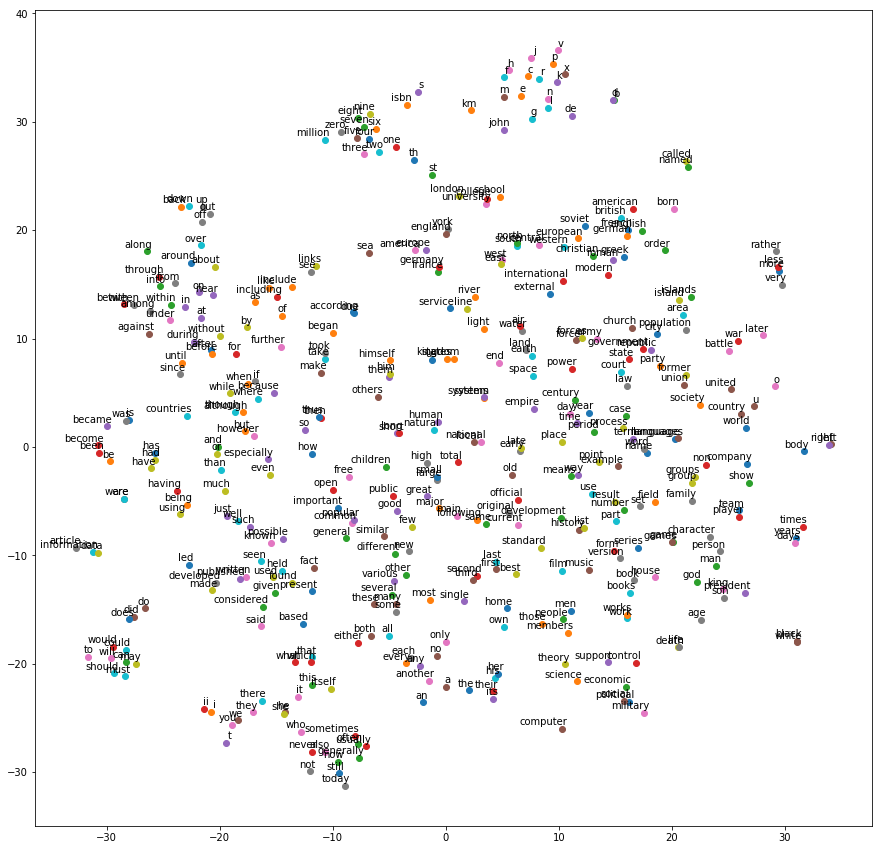

In [22]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels)
    pylab.figure(figsize = (15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points', 
                       ha = 'right', va = 'bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

In [24]:
tsne.kl_divergence_

0.94620577193464894